In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from textblob import download_corpora
import textblob
from textblob import TextBlob

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

from collections import Counter



In [2]:
# Set environment variables for single-threaded execution
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"



In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\35383\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\35383\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\35383\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# from google.colab import files

# # Upload the file
# uploaded = files.upload()

# # Get the filename
# filename = list(uploaded.keys())[0]

# # Read the CSV file into a DataFrame
# data = pd.read_csv(filename)


In [4]:
file_path = 'reviews.csv'
data = pd.read_csv(file_path)


In [5]:
data.head()

,Review date,Guest name,Reservation Number,Review title,Positive review,Negative review,Review score,Staff,Cleanliness,Location,Facilities,Comfort,Value for money,Property reply
0,2021-05-26 13:52:54,Sarah,2.916039e+09,Great stay,"Lovely staff, lovely clean hotel, great food",NaN,10.0,10.0,10.0,7.5,10.0,10.0,10.0,Thank you for taking the time to share your re...
1,2021-05-26 17:25:42,Diana,3.068738e+09,NaN,Location,NaN,9.0,10.0,7.5,10.0,10.0,10.0,10.0,"Dear Diana,\nThank you for the 9/10 rating.\nI..."
2,2021-05-27 13:25:33,ryane,2.505493e+09,Great hotel with helpful friendly staff.,NaN,NaN,10.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN
3,2021-05-28 09:27:09,lorraine,3.332737e+09,NaN,The room was spotless and the food was fabulous.,NaN,9.0,10.0,7.5,10.0,10.0,10.0,10.0,"Dear Lorraine,\nThanks for the great review of..."
4,2021-05-30 17:15:46,Mike,2.650766e+09,NaN,"Great location, excellent food and friendly st...",NaN,10.0,10.0,10.0,10.0,7.5,10.0,10.0,"Dear Mike, \nThank you for the great review an..."


In [6]:
data = data.drop(['Review date', 'Guest name', 'Reservation Number','Review title','Staff','Cleanliness','Location','Facilities','Comfort','Value for money','Property reply' ], axis=1)
data.dropna(inplace=True)

In [7]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word, wordnet.VERB) for word in words]
    return ' '.join(lemmatized_words)


In [8]:
# Combine the 'Positive review' and 'Negative review' columns into a single 'Review' column
data['Review'] = data['Positive review'].fillna('') + ' ' + data['Negative review'].fillna('')

In [9]:
# Apply lemmatization to the 'Review' column
data['Review'] = data['Review'].apply(lemmatize_text)

In [10]:
# Adapt the sentiment classification to the review scores in our dataset
#data['Sentiment'] = data['Review score'].apply(lambda x: 'Positive' if x > 6 else ('Neutral' if x == 5 else 'Negative'))

In [11]:
data.head()

,Positive review,Negative review,Review score,Review
5,Everything was amazing staff room bar staff ð,Everything was great amazing time,10.0,Everything be amaze staff room bar staff ð ...
7,Location is great. Room was very clean and com...,Staff trying to come into our room with no rea...,8.0,Location be great. Room be very clean and comf...
8,Spotless clean food was great and staff where ...,Nothing got what you paid for couldn’t fault it,10.0,Spotless clean food be great and staff where v...
9,I really loved the room it was lovely and clean,I liked everything!!,10.0,I really love the room it be lovely and clean ...
10,"Convenient location, clean and tidy with excel...",A little run down looking from the outside. Co...,8.0,"Convenient location, clean and tidy with excel..."


## Applying Textblob

In [12]:
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'



In [13]:
# Apply sentiment analysis to both columns
data['Review Sentiment'] = data['Review'].apply(get_sentiment)


In [14]:
data.head()

,Positive review,Negative review,Review score,Review,Review Sentiment
5,Everything was amazing staff room bar staff ð,Everything was great amazing time,10.0,Everything be amaze staff room bar staff ð ...,Positive
7,Location is great. Room was very clean and com...,Staff trying to come into our room with no rea...,8.0,Location be great. Room be very clean and comf...,Positive
8,Spotless clean food was great and staff where ...,Nothing got what you paid for couldn’t fault it,10.0,Spotless clean food be great and staff where v...,Positive
9,I really loved the room it was lovely and clean,I liked everything!!,10.0,I really love the room it be lovely and clean ...,Positive
10,"Convenient location, clean and tidy with excel...",A little run down looking from the outside. Co...,8.0,"Convenient location, clean and tidy with excel...",Positive


In [15]:
data['Review Sentiment'].value_counts()

Review Sentiment
Positive    1112
Neutral      292
Negative     107
Name: count, dtype: int64

C:\Users\35383\AppData\Local\Temp\ipykernel_26112\888952294.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Review score',data=data, palette='YlGnBu_r')


<Axes: xlabel='Review score', ylabel='count'>

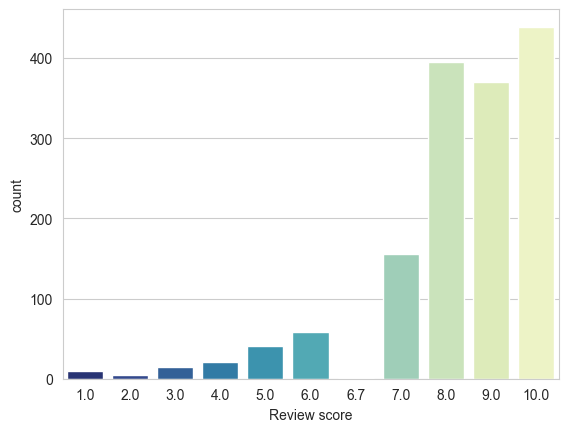

In [16]:
sns.set_style('whitegrid')
sns.countplot(x='Review score',data=data, palette='YlGnBu_r')

C:\Users\35383\AppData\Local\Temp\ipykernel_26112\4280014457.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Review Sentiment',data=data, palette='summer')


<Axes: xlabel='Review Sentiment', ylabel='count'>

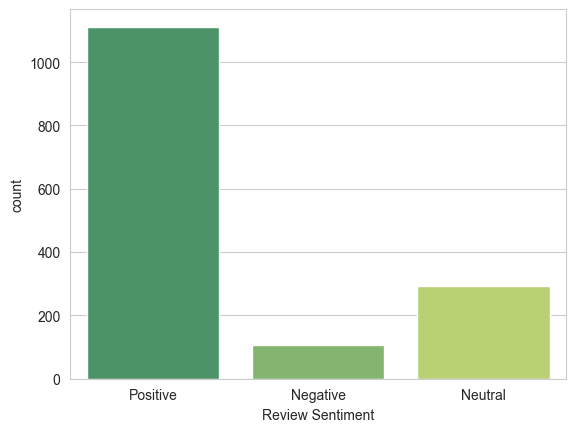

In [17]:
sns.set_style('whitegrid')
sns.countplot(x='Review Sentiment',data=data, palette='summer')

Data Processing

In [18]:
def get_text_processing(text):
    # Remove unwanted characters and keep only letters and numbers
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize and remove stopwords
    stpword = stopwords.words('english')
    words = text.split()
    return ' '.join([word for word in words if word not in stpword])

In [19]:
data['review'] = data['Review'].apply(get_text_processing)

In [20]:
data.head()

,Positive review,Negative review,Review score,Review,Review Sentiment,review
5,Everything was amazing staff room bar staff ð,Everything was great amazing time,10.0,Everything be amaze staff room bar staff ð ...,Positive,everything amaze staff room bar staff everythi...
7,Location is great. Room was very clean and com...,Staff trying to come into our room with no rea...,8.0,Location be great. Room be very clean and comf...,Positive,location great room clean comfortable short st...
8,Spotless clean food was great and staff where ...,Nothing got what you paid for couldn’t fault it,10.0,Spotless clean food be great and staff where v...,Positive,spotless clean food great staff welcome helpfu...
9,I really loved the room it was lovely and clean,I liked everything!!,10.0,I really love the room it be lovely and clean ...,Positive,really love room lovely clean like everything
10,"Convenient location, clean and tidy with excel...",A little run down looking from the outside. Co...,8.0,"Convenient location, clean and tidy with excel...",Positive,convenient location clean tidy excellent staff...


In [21]:
data_model = data[['review', 'Review Sentiment']]

In [22]:
data_model.head()

,review,Review Sentiment
5,everything amaze staff room bar staff everythi...,Positive
7,location great room clean comfortable short st...,Positive
8,spotless clean food great staff welcome helpfu...,Positive
9,really love room lovely clean like everything,Positive
10,convenient location clean tidy excellent staff...,Positive


In [23]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1511 entries, 5 to 5284
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review            1511 non-null   object
 1   Review Sentiment  1511 non-null   object
dtypes: object(2)
memory usage: 35.4+ KB


In [24]:
one_hot = pd.get_dummies(data_model["Review Sentiment"])
data_model.drop(['Review Sentiment'],axis=1,inplace=True)
data_model = pd.concat([data_model,one_hot],axis=1)
data_model.head()

C:\Users\35383\AppData\Local\Temp\ipykernel_26112\2024612391.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model.drop(['Review Sentiment'],axis=1,inplace=True)


,review,Negative,Neutral,Positive
5,everything amaze staff room bar staff everythi...,False,False,True
7,location great room clean comfortable short st...,False,False,True
8,spotless clean food great staff welcome helpfu...,False,False,True
9,really love room lovely clean like everything,False,False,True
10,convenient location clean tidy excellent staff...,False,False,True


In [25]:
X = data_model['review'].values
y = data_model.drop('review', axis=1).values


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [27]:
vect = CountVectorizer()
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

In [28]:
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
#X_train = X_train.toarray()
#X_test = X_test.toarray()


In [29]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [30]:
# Verify the distribution
print(f"Original dataset shape: {Counter(np.argmax(y_train, axis=1))}")
print(f"Resampled dataset shape: {Counter(np.argmax(y_resampled, axis=1))}")


Original dataset shape: Counter({2: 891, 1: 236, 0: 81})
Resampled dataset shape: Counter({2: 891, 1: 891, 0: 891})


In [31]:
# Combine the resampled data into a DataFrame (Note: X_resampled needs to be converted to a dense format)
data_balanced = pd.DataFrame(X_resampled.toarray(), columns=vect.get_feature_names_out())
data_balanced = pd.concat([data_balanced, pd.DataFrame(y_resampled, columns=one_hot.columns)], axis=1)

In [32]:
model = Sequential()

model.add(Dense(units=128, input_dim=X_resampled.shape[1], activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=32,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=3, activation='softmax'))

opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

C:\Users\35383\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
# Train the model with a different batch size and more epochs
history = model.fit(X_resampled, y_resampled, validation_data=(X_test, y_test), epochs=20, batch_size=256, verbose=1, callbacks=[early_stop])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.3324 - loss: 1.0967 - val_accuracy: 0.7030 - val_loss: 1.0803
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4202 - loss: 1.0778 - val_accuracy: 0.7525 - val_loss: 1.0272
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4906 - loss: 1.0246 - val_accuracy: 0.8119 - val_loss: 0.9124
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6023 - loss: 0.9111 - val_accuracy: 0.8383 - val_loss: 0.7411
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7319 - loss: 0.7325 - val_accuracy: 0.8449 - val_loss: 0.5395
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8381 - loss: 0.5255 - val_accuracy: 0.8614 - val_loss: 0.4010
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8801 - loss: 0.3944 - val_accuracy: 0.8779 - val_loss: 0.3459
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9269 - loss: 0.2787 - val_accuracy: 0.8779 - v

In [34]:
# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


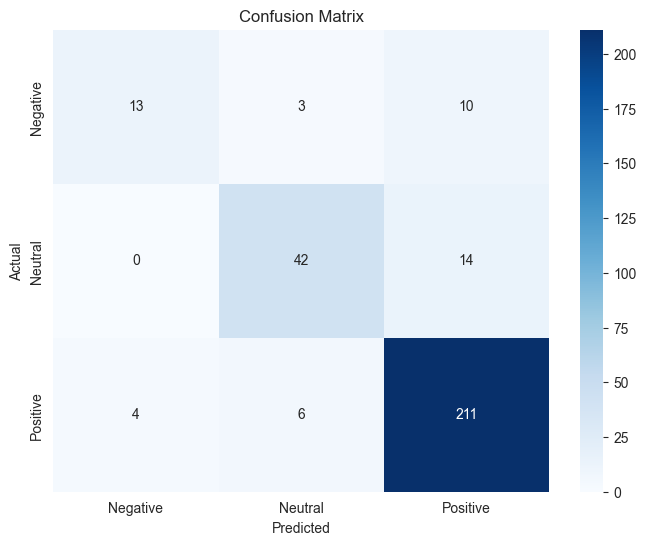

              precision    recall  f1-score   support

    Negative       0.76      0.50      0.60        26
     Neutral       0.82      0.75      0.79        56
    Positive       0.90      0.95      0.93       221

    accuracy                           0.88       303
   macro avg       0.83      0.73      0.77       303
weighted avg       0.87      0.88      0.87       303



In [35]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=one_hot.columns, yticklabels=one_hot.columns)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=one_hot.columns))

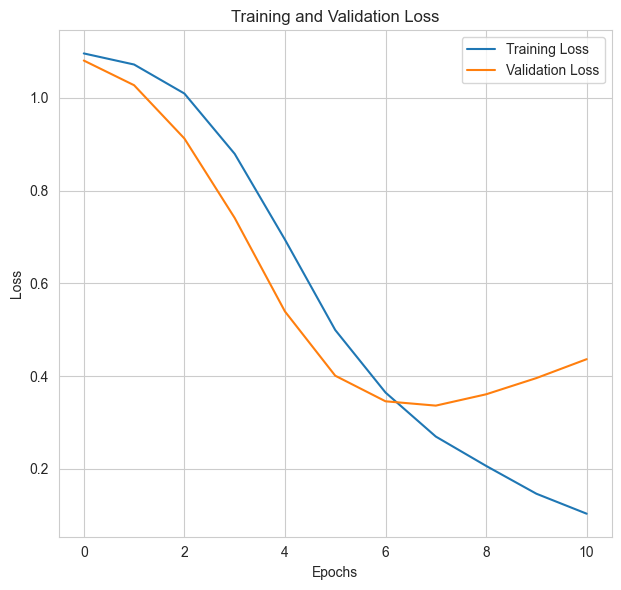

In [36]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()


plt.tight_layout()
plt.show()